# 1. Motivation

## Dataset
We chose to work with the [Harry Potter wikia](http://harrypotter.wikia.com/wiki/Main_Page). The Wikia holds just about all information there is for the Harry Potter movies. This includes everything from characters to plants and spells present in the movies. As bonus we will also analyze the transcripts of the movies, which available on the [transcript Wikia](http://transcripts.wikia.com/wiki/Category:Harry_Potter_Transcripts), and contains everything that was said in the movies.

## Why?
We both grew up with Harry Potter and therefore found it obvious to try and analyze the Harry Potter Wikia. That way we could maybe find relations or connections that we knew nothing about before, or just in general get a better idea of how everything in the Harry Potters universe actually fits together. We also thought that the website would appeal to many other people with the same interest in Harry Potter as us.

We chose Harry Potter Wikia because it is easily accesible and it is possible to do varies amount of analysis. There are 8 Harry Potter movies, plenty of characters, many different places and more.

## Goal
The goal for the project is to show how interesting graph theory can be when it is used on something very mainstream. By utilizing all the techniques learned in class, we want to be able to analyze the Harry Potter universe, in order to obtain deeper insight. We also hope to perform a temporal sentiment analysis on the transcripts, in order to be able find at which timestamps in the movies there are peaks in the sentiment, and to explore how sentiment evolves through out the 8 movies.

The website is a very tangible way for anybody to show the possiblities with these tools, and allow for some more complex and interactive plots, than what is possible in a PDF. We hope to take advantage of this a use a javascript library to create an interactive version of the network, such that the users can more closely explore the network.

# 2. Basic stats
## Imports for whole project

In [1]:
import urllib2
import json
import io
import pandas as pd
import numpy as np
import math
import string
import re
import os
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
import mwparserfromhell
import community
import networkx as nx
from fa2 import ForceAtlas2
import random
import operator
%matplotlib inline
plt.style.use('ggplot')

## Data extraction and cleaning

### Harry Potter Wikia
We extract all our data directly from the the Wikia sites. We start by getting the characters from the Harry Potter Wikia. We want to obtain all the characters within the 5 categories

```
Category:Gryffindors
Category:Hufflepuffs
Category:Ravenclaws
Category:Slytherins
Category:Unknown_House
```

However Wikipedia categories can contain sub-categories, so we start by traversing down all the 5 categories above, and obtaining all the subcategories within each category. Now that we have all the subcategories for each house, we can run a query each of the categories to obtain all of the characters. We make sure to save their pageid and Wiki page-name and what house they are from in a panda dataframe. We then export this to a ".csv" file. We now have a ".csv" file that makes it easy for us look up all the characters wiki pages.

In [3]:
basequery = 'http://harrypotter.wikia.com/api.php?action=query&format=json&cmlimit=500'

houses = ['Category:Gryffindors', 
          'Category:Hufflepuffs', 
          'Category:Ravenclaws', 
          'Category:Slytherins', 
          'Category:Unknown_House']

def create_query(params):
    return basequery+'&' + '&'.join(params)

def create_subcategory_query(cmtitle):
    return create_query(['list=categorymembers', 'cmtitle='+cmtitle, 'cmtype=subcat'])

def create_page_query(cmtitle):
    return create_query(['list=categorymembers', 'cmtitle='+cmtitle, 'cmtype=page'])

# It returns all the sub categories that is found inside the different houses (Gryffindor, etc.)
# We use these to look up all the different sub categories to get names of the characters in the houses
def get_sub_categories(title):
    try:
        query = create_subcategory_query(title)
        query = query.replace(' ', '%20')
        response =  urllib2.urlopen(query)
    except Exception as e:
        print(e)
        print(query)
        return [title]
    response_dict = json.loads(response.read())
    if 'query' not in response_dict:
        return [title]
    return [title] + [c for d in response_dict['query']['categorymembers'] \
                      for c in get_sub_categories(d['title'])]

In [4]:
# Extracting the name and house for all the characters in a dataframe, and then exported to a ".csv" file.
pages = []
count = 0

for house in houses:
    # All sub categories of the house returned
    cs = get_sub_categories(house)
    for c in cs:
        # Getting the characters in the subcategory
        query = create_page_query(c)
        query = query.replace(' ', '%20')
        response =  urllib2.urlopen(query)
        
        # Retrieving the characters in the query and saving them
        response_dict = json.loads(response.read())
        for p in response_dict['query']['categorymembers']:
            if 'User:' in p['title'] or 'Template:' in p['title']: continue
            pages.append((p['pageid'], p['title'], house.split(':')[1]))
            
df = pd.DataFrame(np.transpose([[p[0] for p in pages], 
                   [p[1] for p in pages], 
                   [p[2] for p in pages]]), 
                  columns=['page_id', 'title', 'House'])
df.to_csv(os.path.join('data', 'character.csv'))

Now that the character csv file is created, it easy to load in the characters names and houses at any point. 

In [6]:
df = pd.read_csv(os.path.join('data', 'character.csv'))
df.head()

Unnamed: 0  page_id             title        House
0           0    33349     Astrix Alixan  Gryffindors
1           1    33353   Filemina Alchin  Gryffindors
2           2     7018  Euan Abercrombie  Gryffindors
3           3    99282      Sakura Akagi  Gryffindors
4           4    99036       Zakir Akram  Gryffindors

We then use the all the characters names to query their wiki pages and save them in ".json" format. This way it easy to load in the data at any point. We name the files after what id that had when we created the character.csv. 

In [7]:
basequery = 'http://harrypotter.wikia.com/api.php?action=query&format=json&prop=revisions&rvprop=content'

def create_query_1(pageid):
    return basequery+'&pageids='+str(pageid)

def format_filename(name):
    return os.path.join('data/%s.json') % (name)

def dump_file(name, data):
    file_name = format_filename(name)
    with io.open(file_name, "w", encoding="utf-8") as f:
        f.write(unicode(json.dumps(data, ensure_ascii=False)))

In [6]:
for pageid in df['page_id']:
    query = create_query_1(pageid)
    response =  urllib2.urlopen(query)
    response_dict = json.loads(response.read())
    for k in response_dict['query']['pages'].keys():
        dump_file(pageid, response_dict['query']['pages'][k]['revisions'][-1]['*'])

As of right now we do not need to clean the pages up further, because we want to look for links to other characters to build a graph showing the whole network of Hogwarts. The clean up will be done in the Sentiment Analysis part where we actually look directly at what is written on the wiki pages.

If we take a closer look at the data we have collected, there is a few characters that are not really "characters". The reason for this is that Harry Potter Wikia is community based, and that means the community create the articles and they might categorize them incorrectly. When looking at the data we found that these pages start with "User:" or "Template:", therefore we check if the name starts with these two strings, and discard them if they do.

### Transcipts
Apart from collecting the characters from Harry Potter Wikia we also collect the transcripts for the movies. The transcripts are collected by querying the categories from the Harry Potter transscripts. This returns a list of all the movies. We then use this list to get all the specific transcripts. The transcripts needs to be cleaned before they can be used for analysis. The methods below are used for creating the query to get the plain text from the Transcripts Wikia. The second method is used for cleaning out all the unnecessary symbols and data in the transcript. This includes stopwords, symbols and more. There is one movie that is not entered in the Transcripts Wikia. This movie's transcipt is found in another place and copied in to a ".txt" file.

In [8]:
markup_regex = r'(\{\{.*\}\}|\[.*\]|\n|\<\/p\>|\#.*\#|\(.W \)|\w+:|\<.*\>)'

We use the regex above to remove as much Wikipedia markup as possible. It looks pretty complicated but basically it's just that we remove any HTML tags and anything within Wiki Media Markup tags.

In [9]:
rvprop ="rvprop=timestamp|content"
rvdir = "rvdir=older" #sort revisions from newest to oldest
limit = "rvlimit=1" #consider only the first revision
def returnTitleQuery(title):
    replaceSpace = title.replace(" ", "_")
    return url + "&titles=" + replaceSpace + "&" + rvprop + "&" + rvdir + "&" + limit

tokenizer = RegexpTokenizer(r'\w+')
stopword_list = stopwords.words('english')

def clean_transcripts(movie_transcripts):
    # Remove markup that does not matter
    movie_transcripts = re.sub(markup_regex,'', movie_transcripts)
    movie_transcripts = movie_transcripts.lower()
    tokens = tokenizer.tokenize(movie_transcripts)
    tokens = [w for w in tokens if w not in stopword_list]
    return [w for w in tokens if w.isalpha()]

In [10]:
#Fetching the movie titles from the transcript Wiki
url = "https://transcripts.wikia.com/api.php?action=query&prop=revisions&format=json"
query = "&list=categorymembers&cmtitle=Category:Harry_Potter_Transcripts"
response =  urllib2.urlopen(url + query)
response_dict_categories = json.loads(response.read())

In [11]:
transcript_dict = {}
transcript_not_clean = {}
allmovies = []
movieTitles = ["Harry Potter and the Philosopher's Stone",
               'Harry Potter and the Chamber of Secrets',
               'Harry Potter and the Prisoner of Azkaban',
               'Harry Potter and the Goblet of Fire',
               'Harry Potter and the Order of the Phoenix',
               'Harry Potter and the Half-Blood Prince',
               'Harry Potter and the Deathly Hallows: Part 1',
               'Harry Potter and the Deathly Hallows: Part 2']

for movie in response_dict_categories["query"]["categorymembers"]:
    queryMovie = returnTitleQuery(movie["title"])
    response =  urllib2.urlopen(queryMovie)
    json_format = json.loads(response.read())
    response_dict = json_format
    for k in response_dict['query']['pages'].keys():
        if movie["title"] == "Harry Potter and the Goblet of Fire":
            fi = open("files/"+movie["title"] + ".txt", "r")
            text = fi.read()
            transcript_dict[movie["title"]] = clean_transcripts(text)
            allmovies = allmovies + transcript_dict[movie["title"]]
            transcript_not_clean[movie["title"]] = text
        else:
            transcript_not_clean[movie["title"]] = response_dict['query']['pages'][k]['revisions'][-1]['*']
            transcript_dict[movie["title"]] = clean_transcripts(response_dict['query']['pages'][k]['revisions'][-1]['*'])
            allmovies = allmovies + transcript_dict[movie["title"]]

The result is two dictionaries. Both of them have the movie titles as key. The item is a tuple containing both the cleaned and non-cleaned transcripts. MovieTitles we have hard coded so that we can get the movies in chronological order. When retrieving the data directly from the transcripts website it comes in alphabetical order.

### Generating the network
In this section we will go through some basic methods for describing our data. We will start by creating a directed graph describing how the different characters are related. Here we use a regular expression to find all the links on the characters wiki pages link to another characters wiki page. The links are inside \[\[`Link`\]\]. This gives us each Harry Potter character as a node and the directed edge is when a page links to another page.

In [12]:
regex = "\[\[(.*?)\]\]"

character_name = np.array(df.title)

G = nx.DiGraph()
for index, row in df.iterrows():
    G.add_node(row['title'], house=row['House'], pageid=row['page_id'])

for index, row in df.iterrows():
    with io.open(format_filename(row['page_id']), 'r', encoding='utf-8') as f:
        content = json.load(f)
    links = re.findall(regex, content)
    
    for link in links:
        for l in link.split('|'): 
            if l in character_name:
                G.add_edge(row['title'], l)

In [13]:
print("There are {} nodes in the whole graph.".format(len(G.nodes)))
print("There are {} edges in the whole graph.".format(len(G.edges)))

There are 851 nodes in the whole graph.
There are 4495 edges in the whole graph.


As can be seen from the output it is quite a big graph with a lot of nodes and edges. We will not try and show the graph in readable way. We do this by utilizing force atlas that helps by calculating positions for the nodes, so they are placed nicely. We also make sure to color the nodes in the colors of the different houses.

In [14]:
def calculate_position(G):
    forceatlas2 = ForceAtlas2(scalingRatio=1.0,
                              strongGravityMode=False,
                              gravity=50.0,
                              verbose=False)
    return forceatlas2.forceatlas2_networkx_layout(nx.Graph(G), pos=None, iterations=3000)

In [15]:
house_color_dict = { # Dict containing the official colors for each house
    'Gryffindors': '#740001',
    'Hufflepuffs': '#ecb939',
    'Slytherins': '#3d6b58',
    'Ravenclaws': '#222f5b',
    'Unknown_House': 'gray'
}

positions = calculate_position(G)
node_degree = [G.degree(n)*0.8+1 for n in G.nodes]
node_colors = [house_color_dict[v['house']] for k, v in G.nodes.data()]

In [16]:
# Add position, color and size as node attributes to dump it as GEXF file
# This file will be used to visualize the graph on the website
for k, v in G.nodes(data=True):
    G.nodes[k]['x'] = positions[k][0]
    G.nodes[k]['y'] = positions[k][1]
    G.nodes[k]['color'] = house_color_dict[v['house']]
    G.nodes[k]['size'] = G.degree(k)*0.8+1

nx.write_gexf(G, os.path.join("docs", "resources", "graph.gexf"))

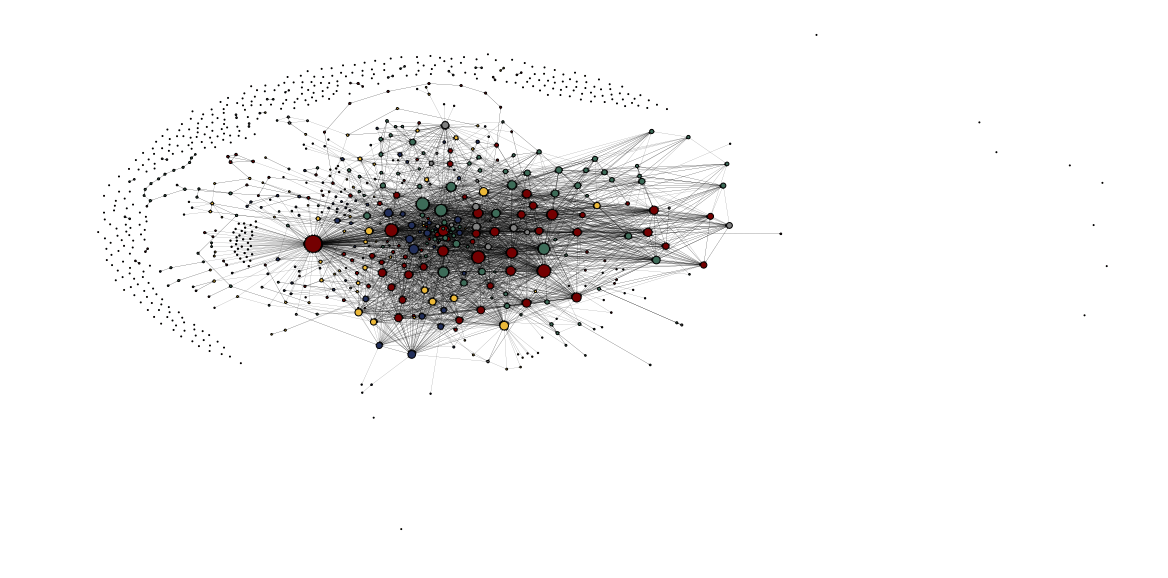

In [17]:
plt.figure(figsize=(20,10))
nx.draw_networkx(G, positions, 
                 cmap=plt.get_cmap('jet'), 
                 node_size=node_degree, 
                 node_color=node_colors, 
                 arrows = True,
                 width = 0.1,
                 with_labels=False,
                 linewidths=1., 
                 arrowsize=2)
plt.gca().collections[0].set_edgecolor("#000000")
plt.axis('off')
plt.show()

Above we see the entire graph from the Harry Potter universe, each node's size is dependent on the node's degree. The biggest red circle that can be seen on the graph is Harry Potter. If you wanna see an even clearer view of the graph go to our website [here](https://thomasoerkild.github.io/TheSocialNetworkOfHogwarts/), where there is an interactive version of the graph. We can now take a look of how the out and in degree distribution looks for the same graph.

### Basic statistics

In [20]:
in_degrees = [sorted([G.in_degree(k) for k, v in G.nodes.data() if v['house'] == h], reverse=True) \
              for h, _ in house_color_dict.iteritems()]
out_degrees = [sorted([G.out_degree(k) for k, v in G.nodes.data() if v['house'] == h], reverse=True) \
              for h, _ in house_color_dict.iteritems()]

all_in_degree = sum(in_degrees, [])
all_out_degree = sum(out_degrees, [])
# Gets the average and median degrees (the average is the same for in- and out-degrees obviously)
print("Average Degree = " + str(np.average(all_in_degree)))
print("Median In-degree = " + str(np.median(all_in_degree)))
print("Median Out-degree = " + str(np.median(all_out_degree)))
print("Highest In-degree = " + str(max(all_in_degree)))
print("Highest Out-degree = " + str(max(all_out_degree)))

Average Degree = 5.282021151586369
Median In-degree = 0.0
Median Out-degree = 1.0
Highest In-degree = 268
Highest Out-degree = 88


Here we can see some of the basic statistics for the graph. One of the most interesting things is the the highest in-degree is substantially bigger then the highest out-degree. In this case it makes sense because pretty much all of the characters in the Harry Potter universe interact with him, so a lot of people link to him in their pages. 

When comparing the median to the average degree there something interesting is shown. Distance between the in-degree median and the average degree is large. The same goes for the out-degree. For the in-degree it means that more than 50% of the nodes has no ingoing edges. For the out-degree it means more than 50% has one or less out going edges. This once agains shows that our network contains a few large hubs, and a lot of small nodes with a very low degree.

In general the small nodes probably links to the bigger nodes (as is the case for Harry Potter), and they do not link back. This means that the out-degree is larger than the in-degree on an average node. The in-degree is only large on a few of the very important characters. 

We can inspect the correlation between the in and out-degree to check whether there is a correlation between a characters that link to a lot of other characters, also is linked to by a lot of characters.

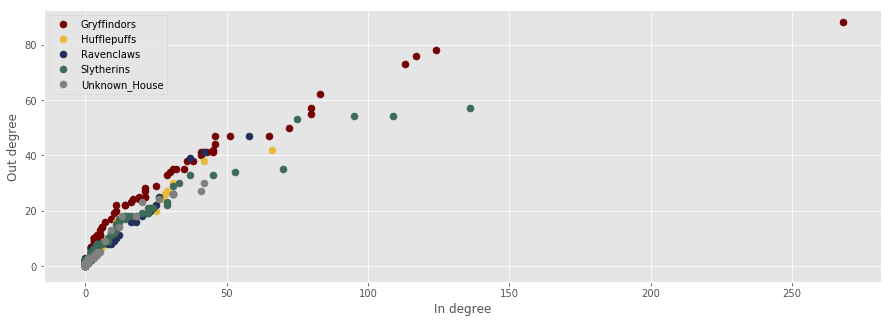

In [21]:
color_list = [v for h, v in house_color_dict.iteritems()]

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
for i, c in enumerate(house_color_dict.itervalues()):
    scatter = ax.scatter(in_degrees[i], out_degrees[i], c=color_list[i],s=50)
plt.xlabel('In degree')
plt.ylabel('Out degree')
plt.legend(house_color_dict)

In [22]:
print("Correlation: " +str(np.corrcoef(sum(in_degrees, []),sum(out_degrees,[]))[0,1]))

Correlation: 0.9143468940820145


The correlation between the in and out degree is 0.91 which means that they are strongly correlated. As mentioned before this is also what we can observe from the plot. This correlation means that people with a high in degree tend to also have a high out degree. Which might be due to the fact that the important characters tend to have a long Wikipedia page, and thus have a greater chance of linking to a lot of people.

### Degree distrubtion
We will now inspect the degree distribution.

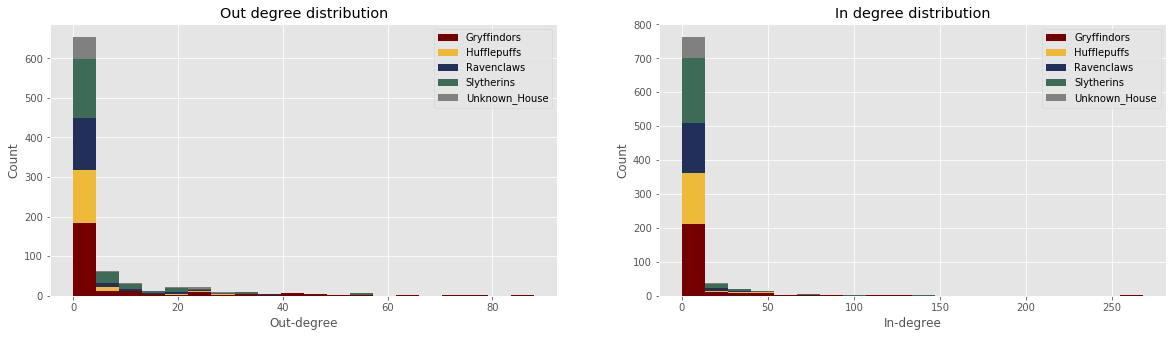

In [23]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(out_degrees, bins = 20, stacked=True, color=color_list)
plt.title('Out degree distribution')
plt.xlabel('Out-degree')
plt.ylabel('Count')
plt.legend(house_color_dict)
plt.subplot(122)
plt.hist(in_degrees, bins = 20, stacked=True, color=color_list)
plt.title('In degree distribution')
plt.xlabel('In-degree')
plt.ylabel('Count')
plt.legend(house_color_dict)

In the graph above we see the in and out degree distributions for each node of the respective houses. As its seen from the graphs most of the nodes have an in-degree and out-degree in the first bin. This is due the fact that, as mentioned earlier, only 521 of the total 851 nodes have a degree of more than zero, so all 330 nodes without any edges will end up in the first bin. From the graphs it seems that only Griffindor and Slytherin have characters with a high in or out degree, but only a few characters have a out-degree of 20 or above, and only a few characters have a in-degree of 30 or above.

Text(0.5,1,'In degree - log scale')

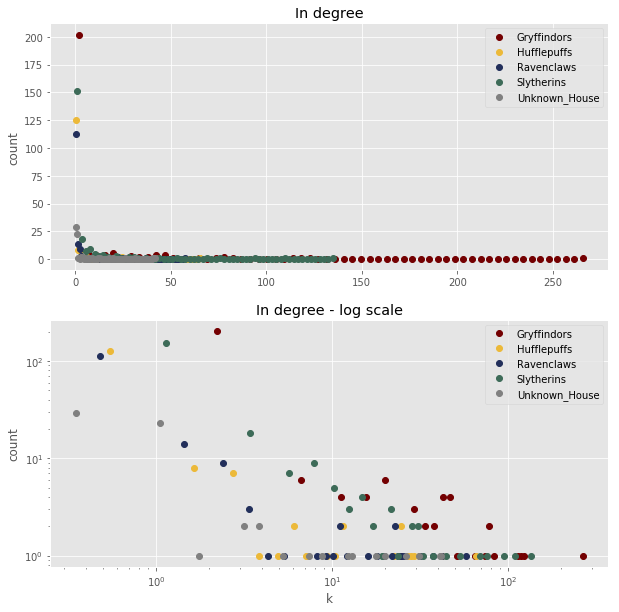

In [24]:
hists = [np.histogram(i, 60) for i in in_degrees]
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
for i, h in enumerate(hists):
    plt.plot(np.diff(h[1]) / 2 + h[1][:-1] , h[0], 'o', color=color_list[i])
plt.ylabel("count")
plt.title('In degree')
plt.legend(house_color_dict)
plt.subplot(2,1,2)
plt.xlabel("k")
plt.ylabel("count")
for i, h in enumerate(hists):
    plt.loglog(np.diff(h[1]) / 2 + h[1][:-1] , h[0], 'o', color=color_list[i])
plt.legend(house_color_dict)
plt.title('In degree - log scale')

Text(0.5,1,'Out degree - log scale')

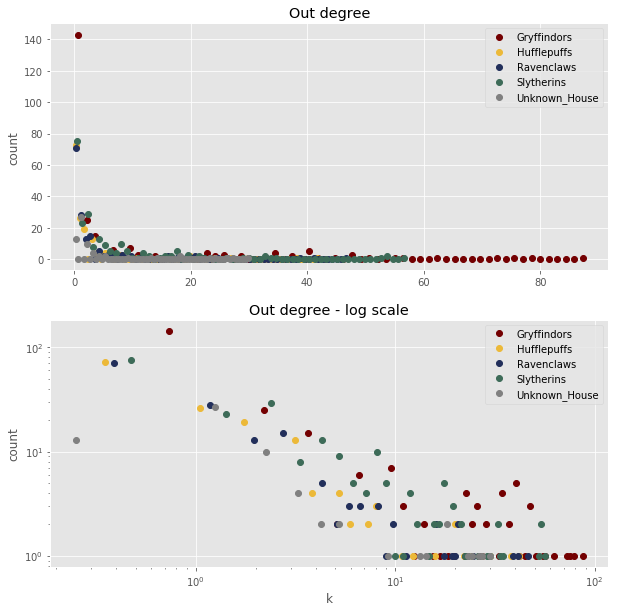

In [25]:
hists = [np.histogram(i, 60) for i in out_degrees]
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
for i, h in enumerate(hists):
    plt.plot(np.diff(h[1]) / 2 + h[1][:-1] , h[0], 'o', color=color_list[i])
plt.ylabel("count")
plt.title('Out degree')
plt.legend(house_color_dict)
plt.subplot(2,1,2)
plt.xlabel("k")
plt.ylabel("count")
for i, h in enumerate(hists):
    plt.loglog(np.diff(h[1]) / 2 + h[1][:-1] , h[0], 'o', color=color_list[i])
plt.legend(house_color_dict)
plt.title('Out degree - log scale')

In the figures above we have the in and out-degree on non-log and log scale. 

The degree distributation of a random network model is well described by a poisson distribution.

$$ p _ { k } = e ^ { - \langle k \rangle } \frac { \langle k \rangle ^ { k } } { k ! } $$ 

But the random network model, underestimates the frequency of high degree nodes of real world networks. The degree distribution of real world networks are often follow a power law distribution, defined as

$$ p _ { k } \sim k ^ { - \gamma } $$

The power law distribution is a straight downward trending line when plotted on a log-log scale. When looking at our distribution in the plot above, it's clear that the network doesn't follow the poission distribution, as we have too many nodes with a very high degree. Our network is more closely following a power law, in the way the there is linear downwarding trend on the log-log scale.

An interesting fact about the power law is the friendship paradox. It states that on average your friends have more friends than you. As our network seems to follow a power law, we check if the friendship paradox is true for our data.

In [42]:
def friendship_paradox(G):
    results = []
    for _ in range(10000):
        node = random.choice(G.nodes.keys())
        if G.out_degree(node) == 0:
            continue
        nb_degrees = [G.degree(n) for n in G.neighbors(node)]
        results.append(G.degree(node) <= np.mean(nb_degrees))
    result = np.sum(results)/float(len(results))
    return result*100

In [43]:
friendship_paradox(G)

95.176796480365

When we calculate the amount of nodes that have a lower degree than the average of their friends, we see that this is true 95% of the time. This confirms our observation from before that the graph does indeed follow a power law.

# 3. Analysis

We have now extracted all the data and can start analysizing. We will use many different tools and theories to examine the network. At the end we will also go through the transcript.

## Centrality measures
In this section we will explore various centrality measurements, to find which charcters are "important". We will use both the betweeness centrality and the eigenvector centrality.

### Betweeness centrality
The betweeness centrality is a measure of how many shortest paths go through a given node. Given a node $v$ we can express the betweeness centrality as:

$$
c _ { B } ( v ) = \sum _ { s , t \in V } \frac { \sigma ( s , t | v ) } { \sigma ( s , t ) }
$$

where $V$ is the set of all nodes in the graph, $\sigma ( s , t )$ is the number of shortest paths between $s$ and $t$, and $\sigma ( s , t | v )$ is the amount of shortest paths between $s$ and $t$ that pass through $v$.

In [44]:
dicts = []
bc = nx.betweenness_centrality(G)
ec = nx.eigenvector_centrality(G)
count = 1
for n in G.nodes:
    dicts.append({'id': count,
                    'name': n,
                    'bc': round(bc[n], 4),
                   'ec': round(ec[n], 4),
                   'in_degree': G.in_degree(n),
                   'out_degree': G.out_degree(n)})
    count +=1

In [45]:
sorted_bc = sorted(bc.items(), key=operator.itemgetter(1), reverse=True)
print("{:<40} {}".format("Character","Betweeness centrality"))
print("------------------------------------------------------------")
for i in range(15):
    print("{:<40} {}".format(sorted_bc[i][0],sorted_bc[i][1]))

Character                                Betweeness centrality
------------------------------------------------------------
Harry Potter                             0.0522131434811
Minerva McGonagall                       0.0169630666878
Albus Dumbledore                         0.0151583322485
Jo King (Slytherin)                      0.0129547258039
M. G. McGonagall                         0.0125368003627
R. J. H. King                            0.0121241702493
Hermione Granger                         0.0108611254841
Andrew Snowy Owl (Slytherin)             0.0103235640546
Neil Lament                              0.00839742257327
Ronald Weasley                           0.00813208444327
Draco Malfoy                             0.00801802940115
Tom Riddle                               0.00795892893151
Angelina Johnson                         0.00755383014174
Winky Crockett (Slytherin)               0.00745098039216
Severus Snape                            0.00633377138785


In the table above we see the top 15 characters based off of betweeness centrality. Unsurprisingly Harry Potter is at the top of this chart. Which makes sense since he has the highest degree, and due to the fact that almost all of the characters in the movies interact with him.


### Eigenvector centrality
The eigenvector centrality is a measure that looks at the centrality of the neighbors. This means that the centrality of a given node will be high, if there are many neighbors, that also have a high centrality score. Since this is the chicken and egg problem we will need to iteratively calculate the centrality of each score until it converges. We intilialize the centrality scores to be $x = \frac{1}{N}$, and iteratively update the centrality scores for each node as

$$
\mathbf { x } = \mathbf { A x }
$$

where $\mathbf { A }$ is the adjecency matrix of the graph.

In [46]:
sorted_ec = sorted(ec.items(), key=operator.itemgetter(1), reverse=True)
print("{:<40} {}".format("Character","Eigenvector centrality"))
print("------------------------------------------------------------")
for i in range(15):
    print("{:<40} {}".format(sorted_ec[i][0],sorted_ec[i][1]))

Character                                Eigenvector centrality
------------------------------------------------------------
Harry Potter                             0.241110676457
Tom Riddle                               0.226775398825
Ronald Weasley                           0.210798118246
Hermione Granger                         0.206451367229
Albus Dumbledore                         0.199050735211
Severus Snape                            0.195477524084
Draco Malfoy                             0.185299227599
Sirius Black                             0.179546293097
Neville Longbottom                       0.172395209704
Dolores Umbridge                         0.164827050883
Minerva McGonagall                       0.158992311248
Rubeus Hagrid                            0.158674408478
Ginevra Weasley                          0.150745071407
Remus Lupin                              0.144470224944
Molly Weasley                            0.140201269133


In the graph above we have the top 15 of characters based off of eigenvector centrality. Here Harry Potter is still number one, but it is interesting to see that Tom Riddle (Lord Voldemort) has the second highest eigenvector centrality, while only having the 11th highest betweeness centrality. This is interresting in the way that a lot of high-degree nodes link to him, but he hasn't got a very high betweeness centrality.

In [47]:
# Store JSON-file to view centralities as a table on the website
with open(os.path.join('docs', 'resources', 'data.json'), 'w') as f:
    json.dump(dicts, f)

## Community Detection

In this analysis we will use the Louvain algorithm to parition the character graph the best way possible. The Louvain algorithm optimizes a modulerity, which is a measure of how well seperated each of the communities are from each other. A graph will have a high modularity if the nodes within a community have many edges to other nodes within the community and few edges to nodes from other communities.

We have a hypothesis that the partitions will be represent to the different houses, so to test this hypothesis we will create a confusion matrix, showing which communities the characters of house is a member of.

The Louvain algorithm is already implemented in a library called community. This is the one we will be using in the code.

In [48]:
nd_G = nx.Graph(G)
# Remove nodes with no edges
nd_G.remove_nodes_from(list(nx.isolates(nd_G)))
partition = community.best_partition(nd_G)
print("The modularity of the partition is {}".format(community.modularity(partition, nd_G)))

The modularity of the partition is 0.322676329356


The modularity is a bit on the low side but we will try and partition the graph anyway to try and see if the communities seems the resemble that of the Hogwarts houses.

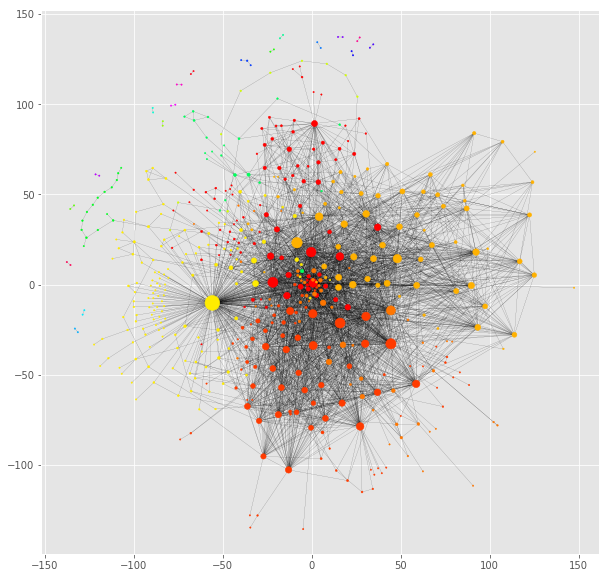

In [49]:
plt.figure(figsize=(10,10))
node_degree = [nd_G.degree(n)*0.8+1 for n in nd_G.nodes]
node_colors = [partition[n] for n in nd_G.nodes]
nx.draw_networkx(nd_G, positions,
                 cmap=plt.get_cmap('hsv'),
                 node_size=node_degree, 
                 node_color=node_colors, 
                 arrows = False,
                 width = 0.1,
                 with_labels=False)

In the graph above we can see the graph, where the color of the nodes describes which community they belong to. You can use the interactive graph on the website (https://thomasoerkild.github.io/TheSocialNetworkOfHogwarts/), if you want to make a closer inspection. 

In [50]:
node_dict = {'Gryffindors' : [k for k, v in nd_G.nodes.data() if v['house'] == 'Gryffindors'],
             'Hufflepuffs' : [k for k, v in nd_G.nodes.data() if v['house'] == 'Hufflepuffs'],
            'Slytherins' : [k for k, v in nd_G.nodes.data() if v['house'] == 'Slytherins'],
             'Ravenclaws' : [k for k, v in nd_G.nodes.data() if v['house'] == 'Ravenclaws'],
             'Unknown_House' : [k for k, v in nd_G.nodes.data() if v['house'] == 'Unknown_House']
}

In [51]:
B = len(node_dict.keys())
C = len(set(partition.values()))
D = np.zeros((B, C))

count = 0
for k, v in node_dict.iteritems():
    p = np.array([partition[n] for n in v])
    for i in range(C):
        D[count, i] = sum(p == i)
    count += 1

(-0.5, 25.5, 4.5, -0.5)

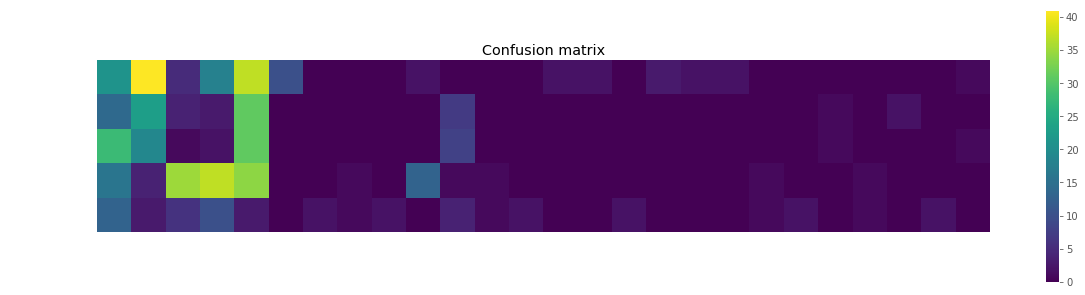

In [52]:
plt.figure(figsize=(20,5))
plt.imshow(D)
plt.xlabel('Community number')
plt.yticks(np.arange(B), list(node_dict.keys()))
plt.title('Confusion matrix')
plt.colorbar()
plt.axis('off')

From the confusion matrix above we see that the communities does *not* capture the house structure of Hogwarts. This can be seen in the way that each house has a lot af members in many different communities, if the communities described the houses, then the majority of members in each house would be assigned to the same community. We can thus discard our hypothesis about the communities of Hogwarts are equal to the houses.

We will now investigate what these communities actually represent.

In [53]:
COMMUNITIES_TO_INVESTIGATE = 5
TOP5 = 10

for i in range(COMMUNITIES_TO_INVESTIGATE):
    print("============== Top {} highest degrees in community {} ============== ".format(TOP5, i))
    nodes = [k for k, v in partition.iteritems() if v == i]
    top_nodes = sorted(nodes, key=lambda x: G.degree(x), reverse=True)[:TOP5]
    for node in top_nodes:
        print('{:<25}  {:<25} Degree: {:<20}'.format(node, nd_G.nodes.data()[node]['house'], nd_G.degree[node]))

============== Top 10 highest degrees in community 0 ============== 
Albus Dumbledore           Gryffindors               Degree: 126                 
Severus Snape              Slytherins                Degree: 116                 
Minerva McGonagall         Gryffindors               Degree: 91                  
Rubeus Hagrid              Gryffindors               Degree: 74                  
William Weasley            Gryffindors               Degree: 54                  
Filius Flitwick            Ravenclaws                Degree: 53                  
Gilderoy Lockhart          Ravenclaws                Degree: 54                  
Jacob's sibling            Unknown_House             Degree: 45                  
Sybill Trelawney           Ravenclaws                Degree: 36                  
Quirinus Quirrell          Ravenclaws                Degree: 32                  
============== Top 10 highest degrees in community 1 ============== 
Ronald Weasley             Gryffindors    

By looking at the out we can see that many of students are being assigned their own community (Community number 1). Ronald Weasley, Hermione Granger, Neville Longbottom and Ginevra Weasley are all students, and they a being assigned to their own community.

The teachers of Hogwarts are also being assigned to the same community (Community number 0). Severus Snape, Albus Dumbledore, Rubus Hagrid and Minerva Mcgonagall are all teacher's at Hogwarts and they are also being assigned to the same community.

In community number 2, however, it seems is able to capture only students from Slytherin. This tells us that Slytherin is pretty different from the other houses, in the way that they are the only house that have community where all the high-degree nodes are from Slytherin. This suggests that they stick more toghether, and primarily interact with other Slytherin people.

## Sentiment

In this section we will try and analyze the Wiki pages sentiment, but also the sentiment of the transcripts for the movie.

### Clean up
Now we have all the content on the wiki pages. The only problems is Harry Potter Wikia do not have the option of querying without all the media wiki markup. We do not care about the markup and just want the plain text top look at. Therefore we use d
the library [mwparserfromhell](https://github.com/earwig/mwparserfromhell), which is able to parse Media Wiki Markup and can provide us with a plain text version. We then tokenize the whole text for each of the Wiki pages, and then we remove all the unnecessary words and symbols. This means stopwords and punctuation. We use the NLTK library to remove stopwords and perform tokenization. 

In [54]:
stopword_list = stopwords.words('english')
stopword_list = stopword_list + [sw.replace('\'', '') for sw in stopword_list]

def tokenize_document(file_name):
    # Load the file, parse it using mwparserfromhell, convert to lowercase, remove stopwords and punctuation
    with io.open(file_name, 'r', encoding='utf-8') as f:
        d = f.read()
        w = mwparserfromhell.parse(d)
        w = w.strip_code().lower()
        tokens = nltk.word_tokenize(w)
        tokens = [t for t in tokens if t not in stopword_list]
        tokens = [t for t in tokens if t not in string.punctuation+'=='+'\'s'+'``'+'\'\'']
        tokens = [t for t in tokens if t if t.isalpha()]
        tokens = [t for t in tokens if t if not len(t) == 1]
        return tokens

In [55]:
token_dict = {row[1].title: tokenize_document(format_filename(row[1].page_id)) for row in df.iterrows()}

Below is the schema showing the sentiment for a list of words. The sentiment scores range from 1.3 to 8.5. Sentiment is a score that tells how positive or negative a word is. The higher it is the more positive it is. 

In [56]:
word_list_df = pd.read_csv('files/Data_Set_S1.txt',delimiter='\t', skiprows=3)
word_list_df.head()

word  happiness_rank  happiness_average  happiness_standard_deviation  \
0   laughter               1               8.50                        0.9313   
1  happiness               2               8.44                        0.9723   
2       love               3               8.42                        1.1082   
3      happy               4               8.30                        0.9949   
4    laughed               5               8.26                        1.1572   

  twitter_rank google_rank nyt_rank lyrics_rank  
0         3600          --       --        1728  
1         1853        2458       --        1230  
2           25         317      328          23  
3           65        1372     1313         375  
4         3334        3542       --        2332

To make it easier to look up the sentiment scores for the words, we will be building a dictionary with the word as key and sentiment score as item.

In [57]:
#Creating dictionary for all words and their happiness average.
happy_dict = {}
for idx, row in word_list_df.iterrows():
    happy_dict[row.word] = row.happiness_average

We also create a function that takes a list of words, and returns the average sentiment score for these words. If non of the words are in the sentiment list, it means that all the words a neutral, so we just return the average sentiment score.

In [101]:
mean_happniess = np.mean(word_list_df.happiness_average)

def calculate_sentiment(tokens):
    tsum = 0.
    count = 0.
    for t in tokens:
        if t in happy_dict:
            tsum += happy_dict[t]
            count += 1
    if tsum == 0:
        return mean_happniess
    return tsum/count

We then create a dictionary, where the character is the key and the item is the average sentiment score.

In [102]:
sentiment_dict = {k: calculate_sentiment(v) for k, v in token_dict.iteritems()}

The `print_list`-function takes a list of top 10 character names and dictionary containing the sentiment score prints them nicely.

In [103]:
def print_list(top, d):
    print("{:<60}  | {:<30}  | {}".format("Character", "Sentiment", "House"))
    print("-"*110)
    for t in top:
        print("{:<60}  | {:<30}  | {}".format(t, d[t], G.nodes.data()[t]['house']))

Now we can sort the `sentiment_dict` in decending order, and take the 10 first elements, which are the 10 characters with the highest sentiment score.

In [104]:
top = sorted(sentiment_dict.keys(), key = lambda x: sentiment_dict[x], reverse=True)[:10]
print("==================== Top 10 highest sentiment characters ====================")
print_list(top, sentiment_dict)

==================== Top 10 highest sentiment characters ====================
Character                                                     | Sentiment                       | House
--------------------------------------------------------------------------------------------------------------
Slytherin student that blames Harry Potter (I)                | 6.3925                          | Slytherins
Hufflepuff boy that blames Harry Potter (II)                  | 6.3925                          | Hufflepuffs
Slytherin student that blames Harry Potter (II)               | 6.3925                          | Slytherins
Oona Ballington                                               | 6.36                            | Gryffindors
Filemina Alchin                                               | 6.2875                          | Gryffindors
Hufflepuff boy that blames Harry Potter (I)                   | 6.2875                          | Hufflepuffs
Unidentified Ravenclaw boy at Hogwarts           

We can do the same, but in ascending order to get the top 10 loweset sentiment characters.

In [105]:
top = sorted(sentiment_dict.keys(), key = lambda x: sentiment_dict[x], reverse=False)[:10]
print("==================== Top 10 loweset sentiment characters ====================")
print_list(top, sentiment_dict)

==================== Top 10 loweset sentiment characters ====================
Character                                                     | Sentiment                       | House
--------------------------------------------------------------------------------------------------------------
Unidentified Ravenclaw boy (III)                              | 4.53333333333                   | Ravenclaws
Wilkes                                                        | 4.56240740741                   | Slytherins
Unidentified Slytherin girl at the Battle of Hogwarts (III)   | 4.66181818182                   | Slytherins
Unidentified Slytherin girl at the Battle of Hogwarts         | 4.76                            | Slytherins
Summerby                                                      | 4.81448275862                   | Hufflepuffs
Unidentified Hogwarts Hufflepuff boy who carried a body during the Battle of Hogwarts  | 4.82571428571                   | Hufflepuffs
Unidentified Hogwarts Rave

As can be seen above the characters that are returned does not make any real sense, and it is really hard to get any sensible analysis. The reason these unfamiliar names are ranked either so low or high is because they have very short wiki pages, that maybe only contain one or two words from the sentiment list of words, and the whole character page sentiment score is then based on those words. 

To try and get some results that can be analyzed we choose to only look at characters with a degree higher than 10.

In [106]:
high_degree_nodes = [x[0] for x in list(G.degree) if x[1] >= 10]
print("There are {} nodes with a degree higher than 10".format(len(high_degree_nodes)))

There are 164 nodes with a degree higher than 10


There are 164 nodes in total that have a degree higher than 10. The same tests will then be run again.

In [107]:
top = sorted(high_degree_nodes, key = lambda x: sentiment_dict[x], reverse=True)[:10]
print("==================== Top 10 highest sentiment characters ====================")
print_list(top, sentiment_dict)

==================== Top 10 highest sentiment characters ====================
Character                                                     | Sentiment                       | House
--------------------------------------------------------------------------------------------------------------
Callidora Black                                               | 6.23807692308                   | Slytherins
Rose Granger-Weasley                                          | 6.05560137457                   | Gryffindors
Charis Black                                                  | 5.98390625                      | Slytherins
Gemma Farley                                                  | 5.954                           | Slytherins
Lily L. Potter                                                | 5.93527593819                   | Gryffindors
Cedrella Black                                                | 5.87414893617                   | Slytherins
Cygnus Black III                                   

In [65]:
top = sorted(high_degree_nodes, key = lambda x: sentiment_dict[x], reverse=False)[:10]
print("==================== Top 10 loweset sentiment characters ====================")
print_list(top, sentiment_dict)

==================== Top 10 loweset sentiment characters ====================
Character                                                     | Sentiment                       | House
--------------------------------------------------------------------------------------------------------------
Wilkes                                                        | 4.56240740741                   | Slytherins
Avery II                                                      | 5.01037414966                   | Slytherins
Evan Rosier                                                   | 5.25461538462                   | Slytherins
Lestrange                                                     | 5.25491525424                   | Slytherins
Ismelda Murk                                                  | 5.27723684211                   | Slytherins
Rodolphus Lestrange                                           | 5.30014925373                   | Slytherins
Vincent Crabbe                                       

Now we actually start to see connections between the movie and the data. Slytherin is viewed as the most evil of the different houses, and this becomes very aparent from the sentiment analysis. All of the ten lowest sentiment characters are from Slytherin. We can even see Bellatrix Lestrange who is one of the Death Eaters, and the most evil witch in Harry Potter. 

On the positive side there are two of the children of the main characters, Rose Granger-Weasly (Daughter of Ron and Hermoine) and Lily Potter (Daughter of Harry and Jenny). Apart from Harry's child, there are three characters from the Black family which is part of Harry's family. They are all Slytherin, but the good kind of Slytherin. Fleamont Potter is also found on the list he is Harry's grandfather. 

To see how the average of the houses sentiment stand up against each other we also decided to make a bar plot.

In [66]:
house_sentiment_dict = {'Gryffindors' : [sentiment_dict[n] for n in node_dict['Gryffindors']],
             'Hufflepuffs' : [sentiment_dict[n] for n in node_dict['Hufflepuffs']],
            'Slytherins' : [sentiment_dict[n] for n in node_dict['Slytherins']],
             'Ravenclaws' : [sentiment_dict[n] for n in node_dict['Ravenclaws']],
             'Unknown_House' : [sentiment_dict[n] for n in node_dict['Unknown_House']]
}
mean_house_sentiment_dict = {k : np.mean(v) for k, v in house_sentiment_dict.iteritems()}

(5.4, 5.9)

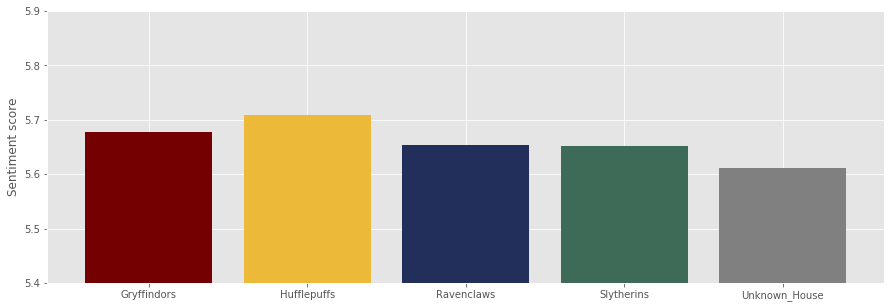

In [67]:
plt.figure(figsize=(15,5))
plt.bar(mean_house_sentiment_dict.keys(), mean_house_sentiment_dict.values(), color=color_list)
plt.ylabel("Sentiment score")
plt.ylim(5.4,5.9)

As can be seen from the bar plot, the Gryffindors are actually not the most positive, which comes as quite a surprise as Gryffindor are the good guys in the movies, and the Hufflepuffs' are more of a side act. The values for Hufflepuff are "valuing hard work, dedication, patience, loyalty, and fair play". These are very positive values and could strongly contribute to why they are the most positive. 

The unknown house is the most negative. This is probably because they mostly consist of very short Wiki pages of characters that died or something else terrible happened to.

To see the general distribution of the Wiki pages we also chose to plot them as a histogram.

Text(0,0.5,'Normalized count')

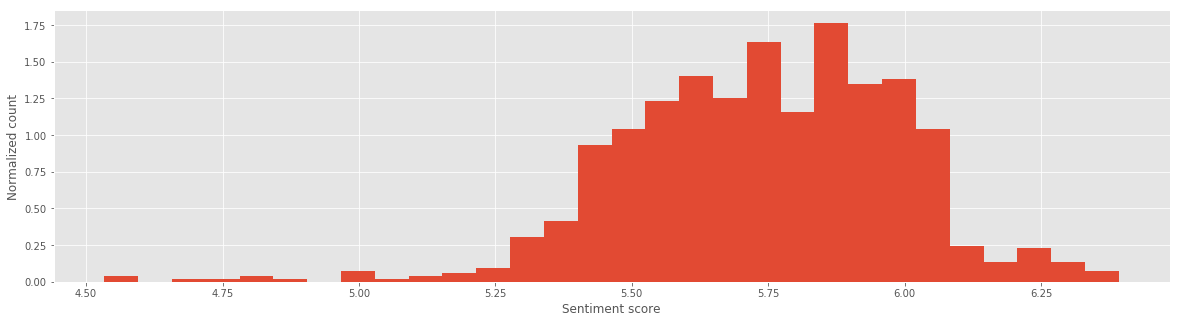

In [68]:
plt.figure(figsize=(20,5))
plt.hist(sentiment_dict.values(), bins=30, density=True)
plt.xlabel("Sentiment score")
plt.ylabel("Normalized count")

In the histogram above we have the sentiment of all of the characters. We see that most of the characters have a sentiment between 5.5 and 6, which is expected since this is around the average sentiment value, and Wikipedia pages tend to be mostly neutral.

Text(0,0.5,'Normalized count')

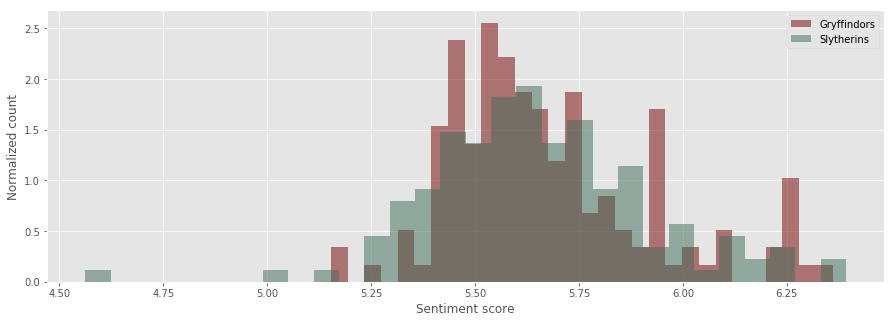

In [69]:
plt.figure(figsize=(15,5))
plt.hist(house_sentiment_dict['Gryffindors'], bins=30, alpha=0.5, color=house_color_dict['Gryffindors'], density=True)
plt.hist(house_sentiment_dict['Slytherins'], bins=30, alpha=0.5, color=house_color_dict['Slytherins'], density=True)
plt.xlabel("Sentiment score")
plt.legend({'Gryffindors' : house_color_dict['Gryffindors'],
            'Slytherins' : house_color_dict['Slytherins']})
plt.ylabel("Normalized count")

From the histogram above we see that Gryffindor and Slytherin generally have approximately the same sentiment scores, but Slytherin have some additional negative outliers. In fact slytherin is generally more spread out, in the way that the loweset and highest sentiment character are both from the Slytherin house.

## Word inspection using TF-IDF

In this section we will investigate which words define each of the houses.
A simple way of defining words that define a house, could be to just count the
most common words. We could define this as
$$
\mathrm { tf } ( t , d ) = f _ { t , d }
$$
where $f _ { t , d }$ is the frequency of term, $t$, in document $d$.

The downside of this approach is that these words don't uniquely
identify a house, as all the houses would probably have almost the same words. A way to
solve this problem is to use <i>TF-IDF</i>, which stands for term-frequency
inverse-document-frequency, he we introduce the term

$$
\operatorname { idf } ( t , D ) = \log \frac { N } { | \{ d \in D : t \in d \} | }
$$

where $N$ is the number of documents in the corpus, and $| \{ d \in D : t \in d \} |$
is the number of documents where term $t$ appears.

By combining all the character's Wikipedias into a single document for each house, we will use the TF-IDF score as a weight to create a word cloud of each house.

In [82]:
def calculate_tfidf(word_dict):
    word_set_dict = {key: set(words) for key, words in word_dict.iteritems()}
    keys = house_word_dict.keys()
    no_documents = float(len(keys))
    
    idf_dict = {}
    tf_dict = {}
    for k, words in word_set_dict.iteritems():
        idf_dict[k] = {}
        tf_dict[k] = nltk.FreqDist(word_dict[k])
        for word in words:
            documents_with_word = np.sum([word in ws for ws in word_set_dict.itervalues()])
            idf_dict[k][word] = np.log(no_documents / documents_with_word)

    tfidf_dict = {}
    for k, words in word_set_dict.iteritems():
        tfidf_dict[k] = {w: idf_dict[k][w] * tf_dict[k][w] for w in word_set_dict[k]}
    return tfidf_dict

In [83]:
house_word_dict = {house: [w for node in nodes for w in token_dict[node]] for house, nodes, in node_dict.iteritems()}
house_tfidf_dict = calculate_tfidf(house_word_dict)

In [70]:
house_word_dict = {house: [w for node in nodes for w in token_dict[node]] for house, nodes, in node_dict.iteritems()}
house_word_set_dict = {house: set(words) for house, words in house_word_dict.iteritems()}
houses = house_word_dict.keys()
no_documents = float(len(houses))

house_idf_dict = {}
house_tf_dict = {}
for house, words in house_word_set_dict.iteritems():
    house_idf_dict[house] = {}
    house_tf_dict[house] = nltk.FreqDist(house_word_dict[house])
    for word in words:
        ds_with_word = np.sum([word in ws for ws in house_word_set_dict.itervalues()])
        house_idf_dict[house][word] = np.log(no_documents / ds_with_word)
        
house_tfidf_dict = {}
for house, words in house_word_set_dict.iteritems():
    house_tfidf_dict[house] = {w: house_idf_dict[house][w]*house_tf_dict[house][w] for w in house_word_set_dict[house]}

In [95]:
def draw_word_cloud(tfidf):
    word_list = [k for k, _, in tfidf.iteritems() for _ in range(int(np.ceil(tfidf[k])))]
    random.shuffle(word_list)
    wordcloud = WordCloud(width=800, height=400, colormap='Blues').generate(' '.join(word_list))
    plt.figure(figsize=(15,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.grid(False)
    plt.axis('off')

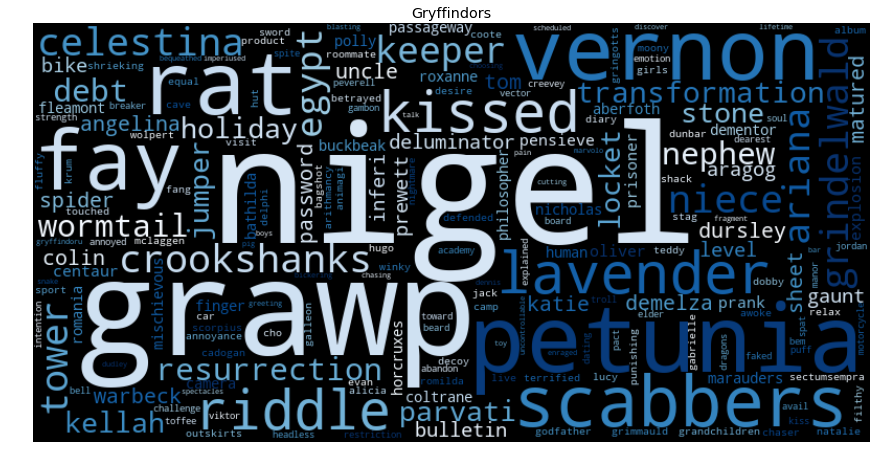

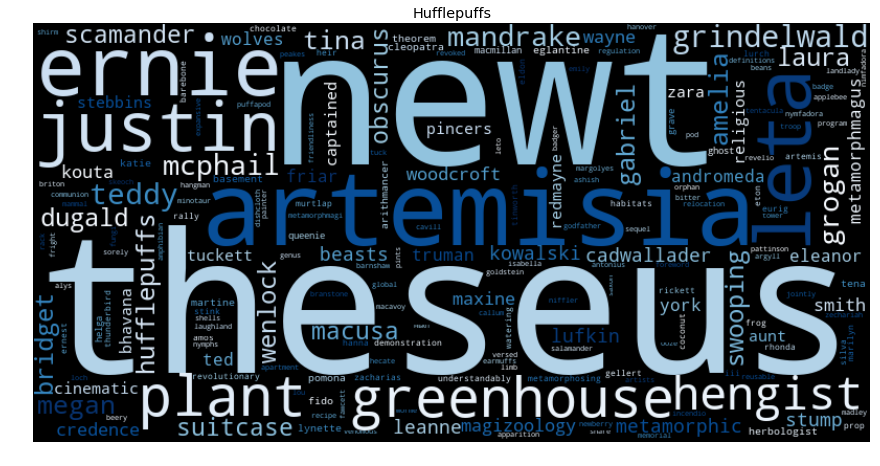

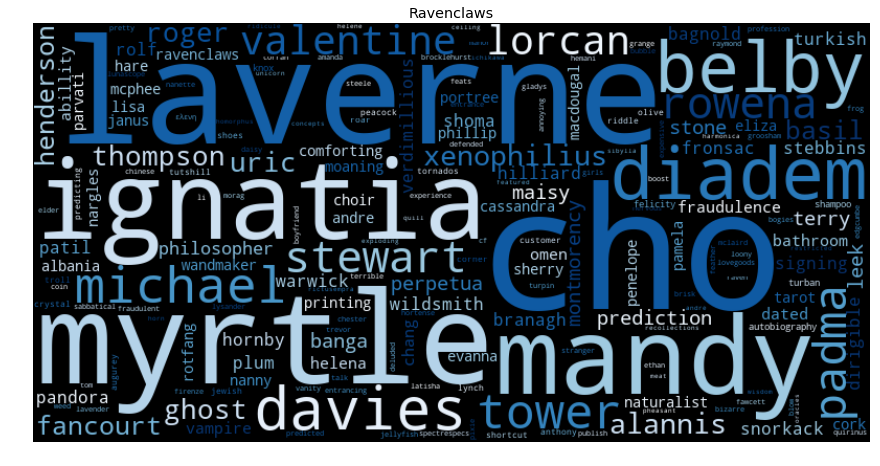

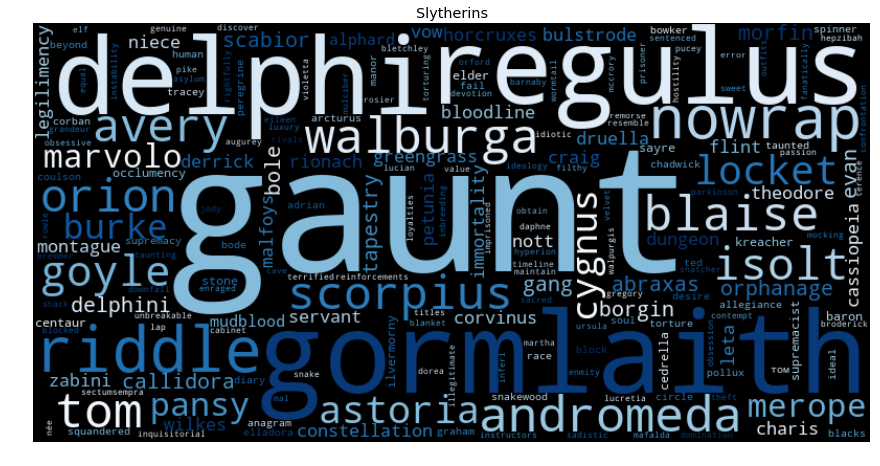

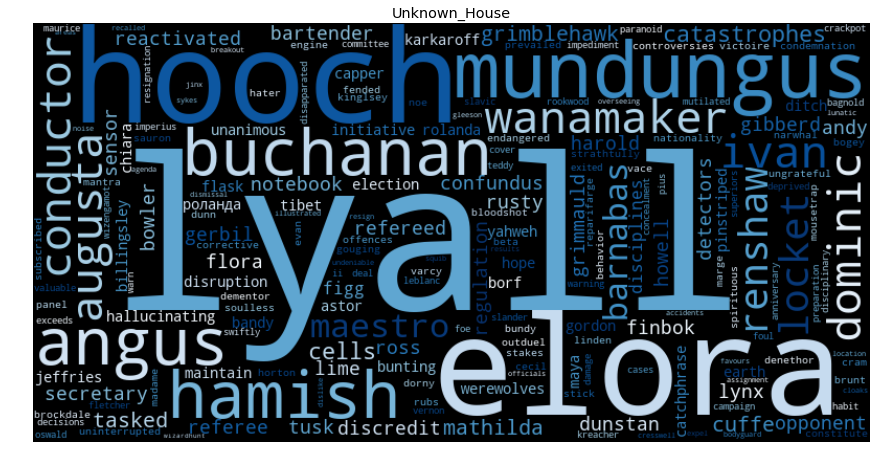

In [96]:
for house in house_color_dict.keys():
    draw_word_cloud(house_tfidf_dict[house])
    plt.title(house)

In the images above we see the word clouds generated using the tf-idf as the weight of each word. As it can be seen a lot of the words used uniquely by each house are names. For example the Gryffindors use the word "Grawp" a lot, which is a giant that appears in some of the movies. 

The Hufflepuffs have words like plant, herbologist and newt, which suggests that Hufflepuffs are very interested in making potions. 

The Ravenclaws use the word "Diadem" a lot, which is a diadem used be the Raveclaw house, to provide wisdom to the person wearing it.

The Slytherins use the word "bloodline", which is related to the fact that, people from Slytherin thinks it is very important what bloodline you come from, such that all your relatives are also wizards. Other than that they use the words "Tom" and "Riddle", which makes sense since he the arguably the most important person from the Slytherin house.

## Transcripts

In this section of the notebook we will go trough the Harry Potter transcripts from the movies. The analysis will be mostly of the sentiment of the language, and what different words are used. The words that are used the most will be found with tf-idf and displayed in a readably way with wordclouds. The sentiment analysis will be done on the transcripts for each movie and will show case how the language changes over time.

First part of getting the movies transcript from Wikia, is to get the categories (movies titles), so we can properly query them.

### Word clouds

With the transcripts downloaded as explained in in the second chapter, it is now possible to do our different analysis. The first is creating words clouds for each of the movies. As part of getting a correctly and move reprensentative wordcloud we choose to create wordclouds based on tf-idf. Tf-idf was explained earlier on in project so will not be repeated.

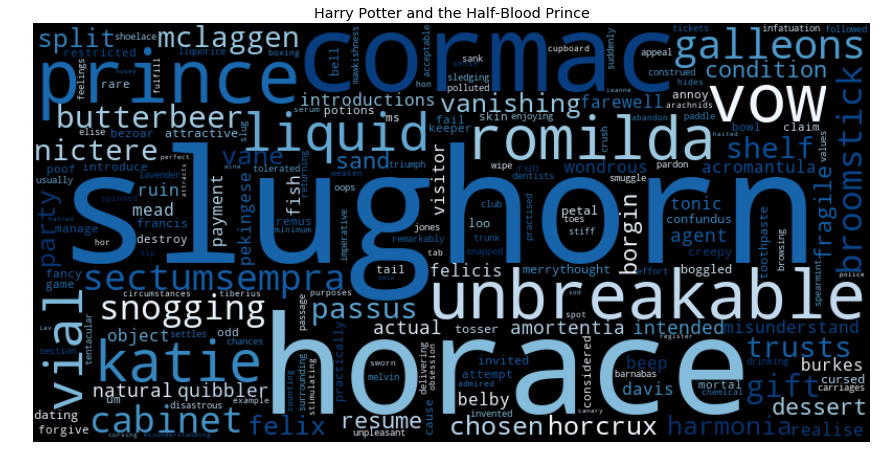

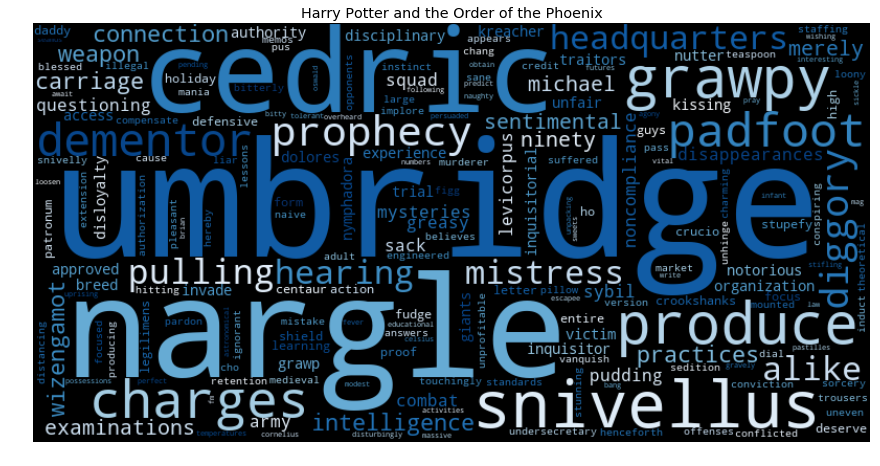

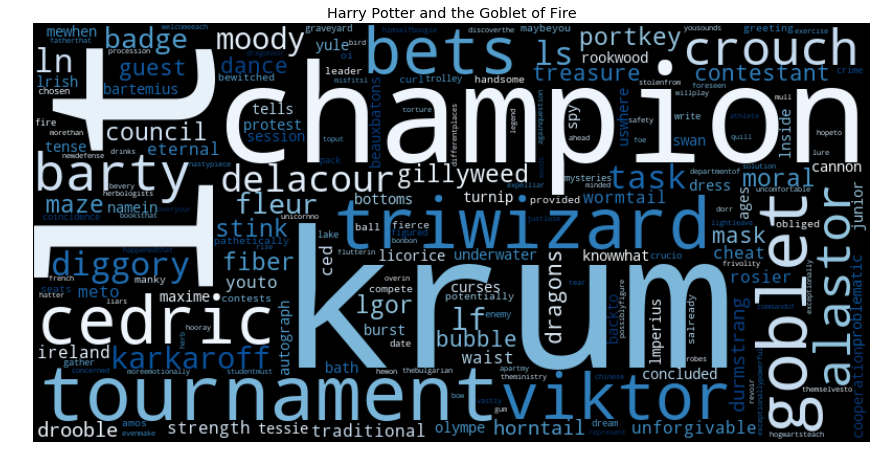

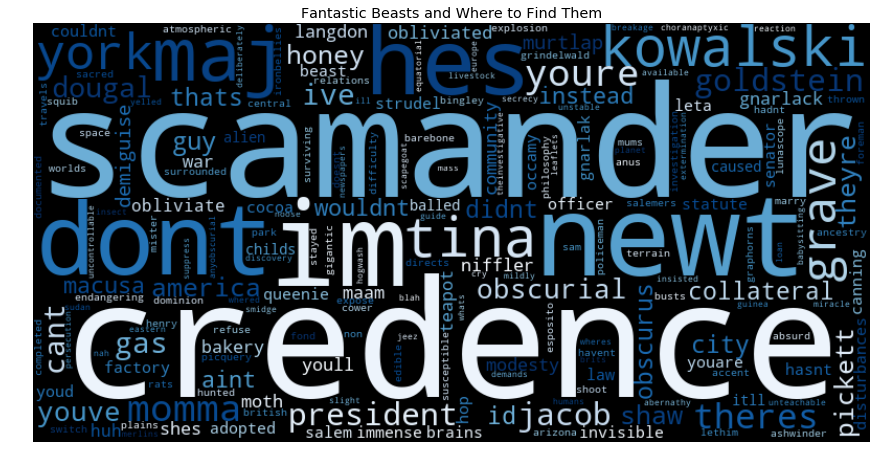

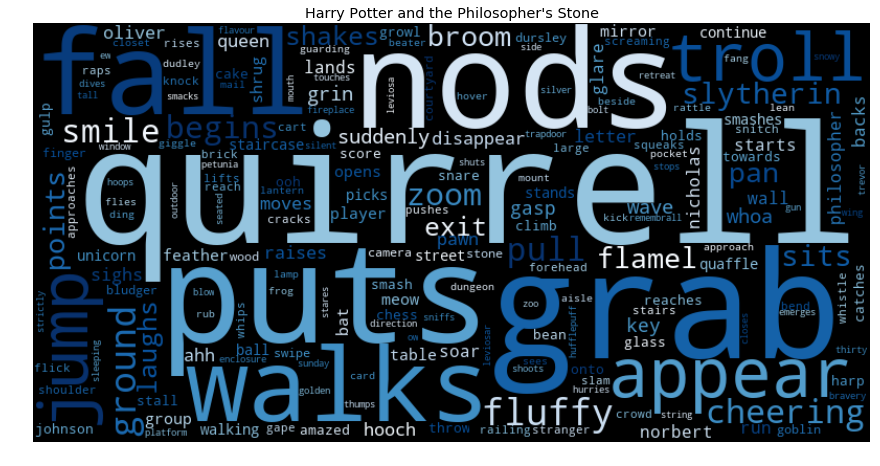

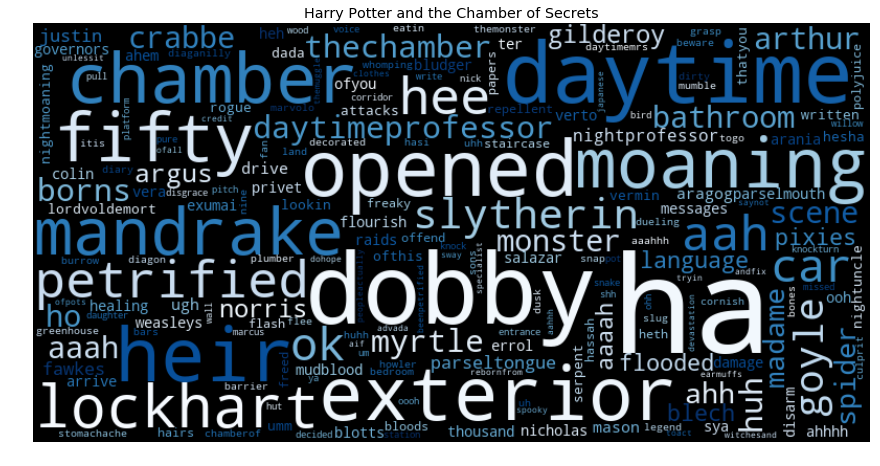

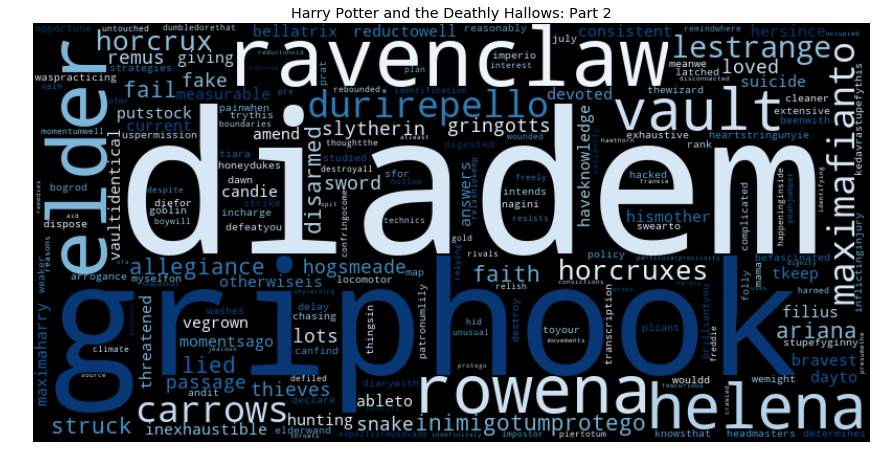

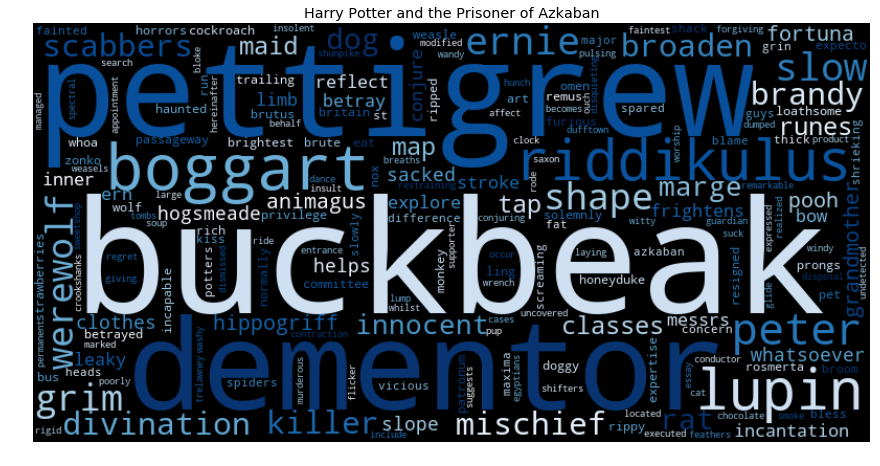

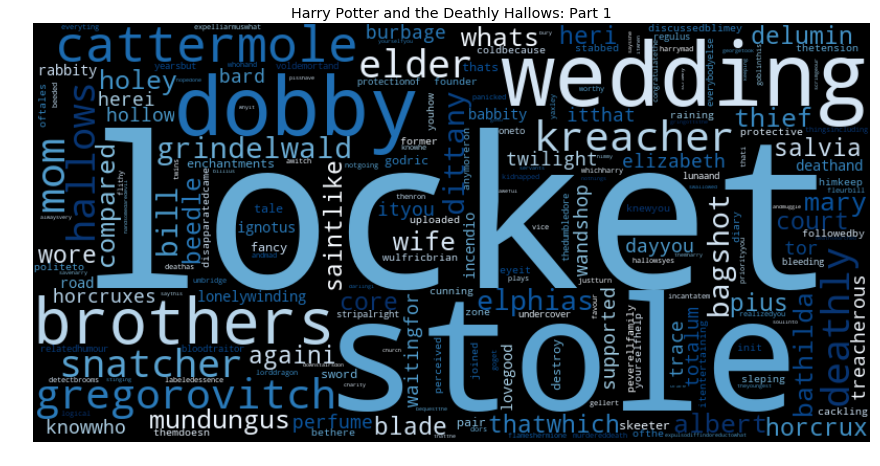

In [97]:
movie_tfidf_dict = calculate_tfidf(transcript_dict)
for movie in movie_tfidf_dict.keys():
    draw_word_cloud(movie_tfidf_dict[movie])
    plt.title(movie)

One thing that beomes very obvious from the wordclouds are the characters only appear in one of the movies. There is quite a few these characters. They are becoming apparent because of the tf-idf. An example could be The Half-blood Prince, where Slughorn is featured as Harry Potters chemistry teacher. In the rest of the movies he is present but never once mentioned again. The same goes for the creature nargle which plays a bit part in the Order of the Phoenix but comes unimportant before and after that movie. 

It is interesting to see that if you have some Harry Potter movie knowledge you could quickly guess from the wordclouds what movie it depicts. This is specifically the tf-idf that makes this easier. 

### Sentiment analysis

Another analysis we want to do for the transcript is looking at how the language changes (or does not) through the movies and if it is possible to might guess event from the transcripts sentiment.

Here we got through the transcripts. We do not make a point for every word in the transcipt because that would make an unreadable plot. Instead we split on every 6th line, so we take about 6 sentences at a time and use as a point on the plot. There is one movie "Harry Potter and the Half-Blood Prince" where the transcript is not seperated by newlines, but everything is written as one large text. Here we chose to take 30 words at a time and calculating the sentiment for these words as one and count them as a point. 

In [100]:
# Create and entry in the dictionary for each movie
sentence_dict = {}
for keys, row in transcript_not_clean.iteritems():
    sentence_dict[keys] = []

#We split the tokens in the movies in to smaller parts, to make plots that are not as clutered. We split every 6 sentence.
for keys, row in transcript_not_clean.iteritems():
    if keys == "Harry Potter and the Half-Blood Prince":
        temps = row.split(" ")
        tempList = []
        count = 0
        for temp in temps:
            if count % 30 == 0:
                sentence_dict[keys].append(tempList)
                tempList = []
            tempList += clean_transcripts(temp)
            count += 1
    else:
        temps = row.split("\n")
        tempList = []
        count = 0
        for temp in temps:
            if count % 6 == 0:
                sentence_dict[keys].append(tempList)
                tempList = []
            tempList += clean_transcripts(temp)
            count += 1


All the text has now been split into smaller parts. Now we calculate the sentiment analysis for each of these smaller parts that we use as points.

In [108]:
#The sentiment is calculated for the new generated lists
sentiment_senctences_dict = {}
for keys, row in sentence_dict.iteritems():
    sentiment_senctences_dict[keys] = [calculate_sentiment(sentence) for sentence in row if len(sentence) != 0]

We then use these points to generate the plots seen below for each of the movies.

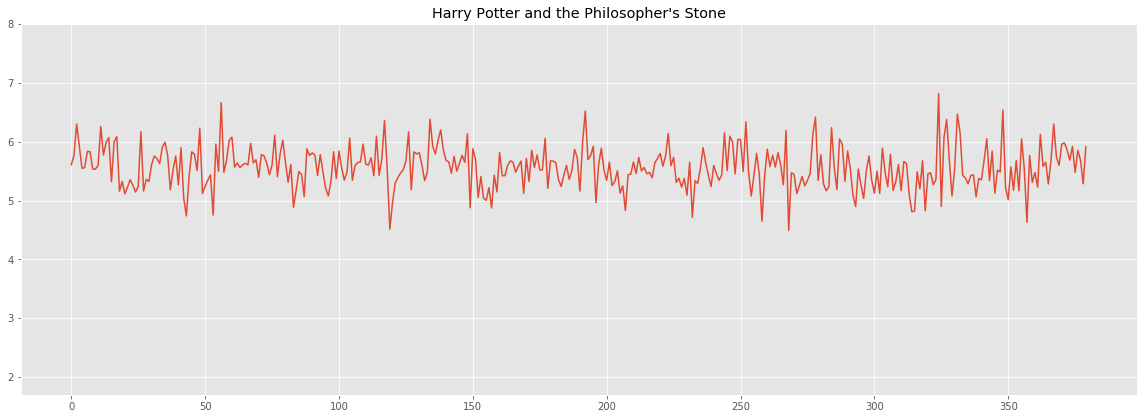

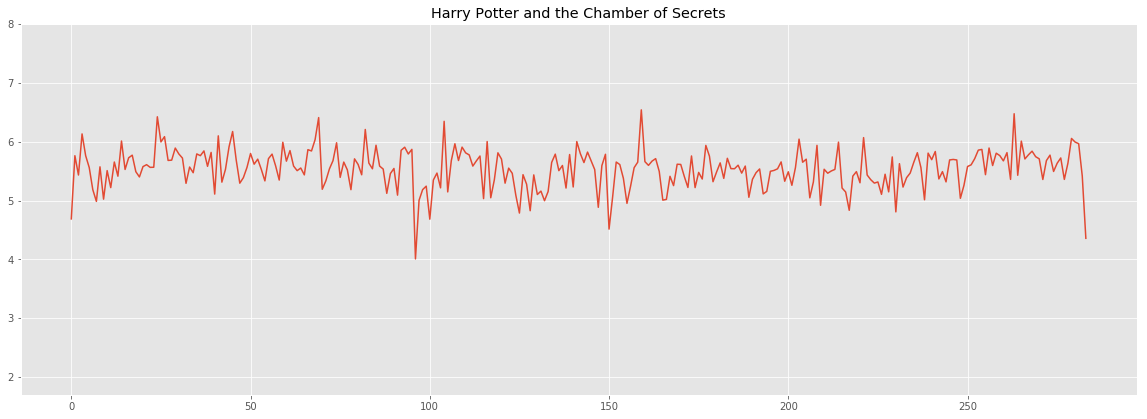

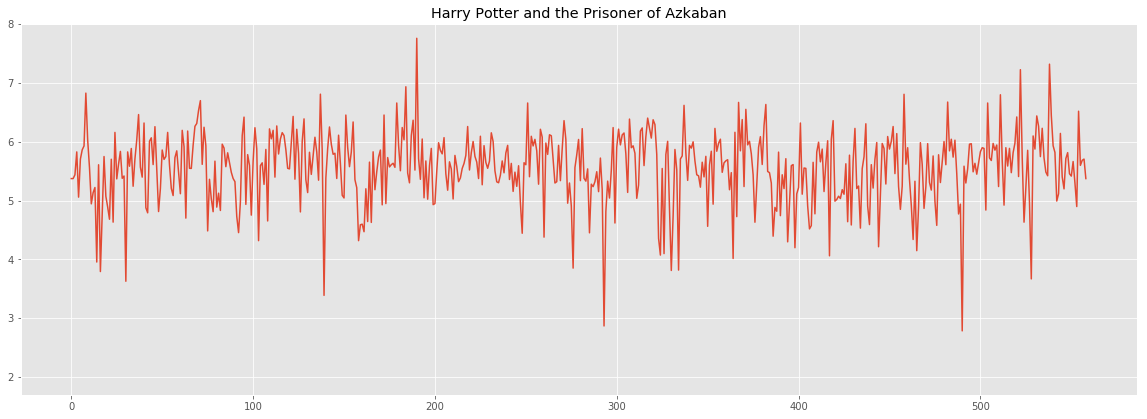

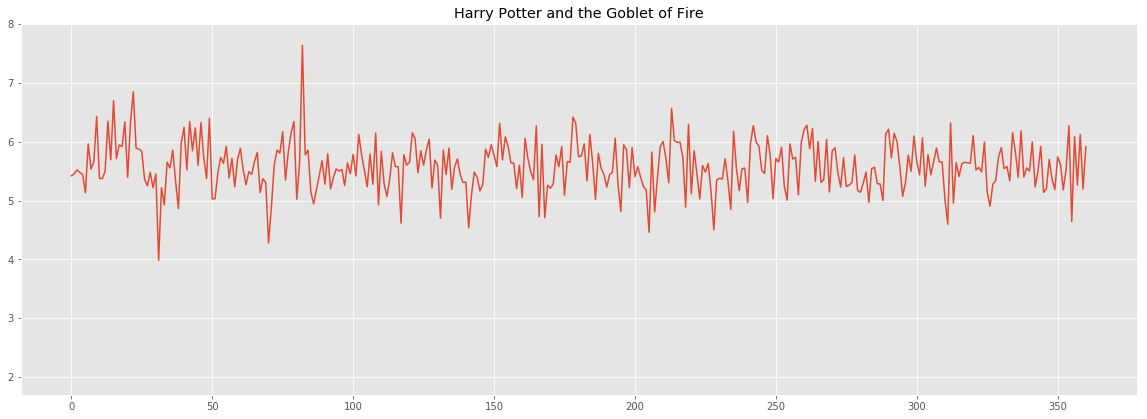

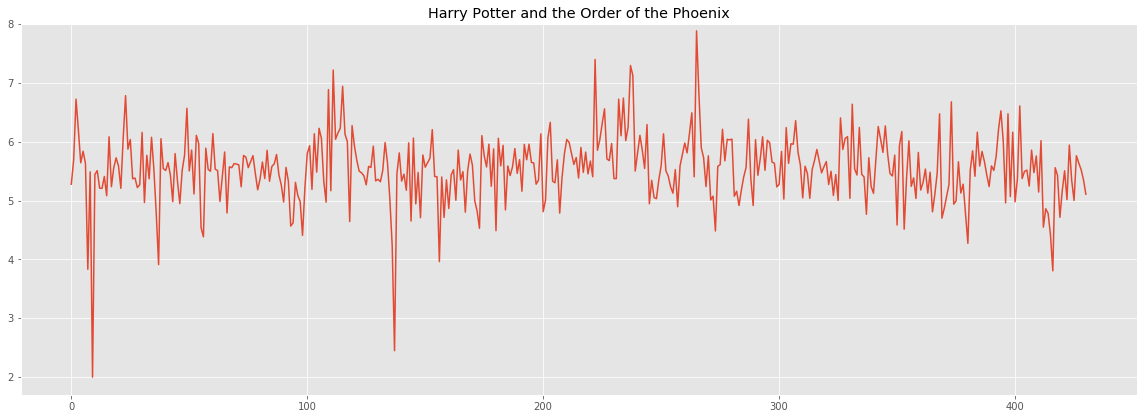

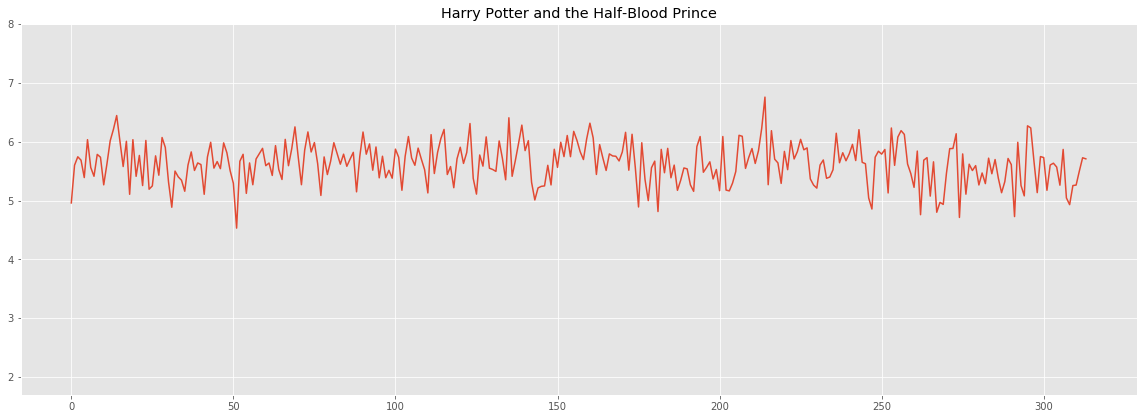

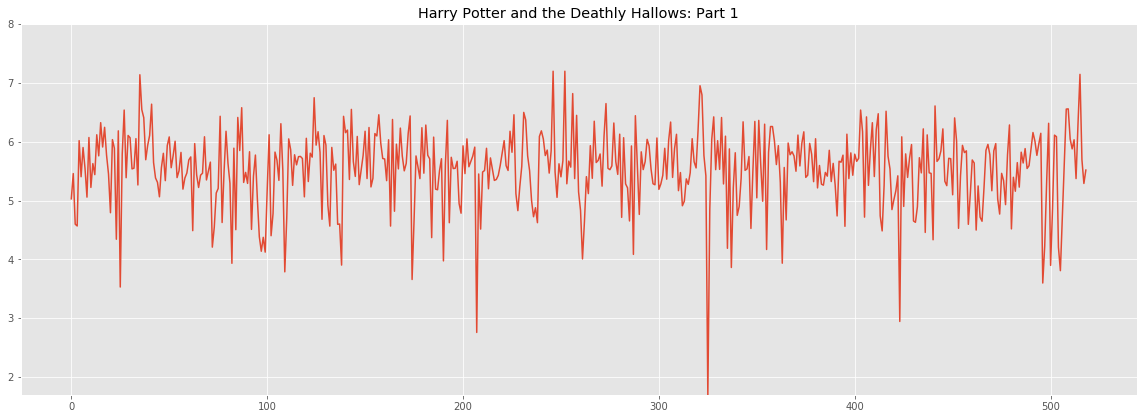

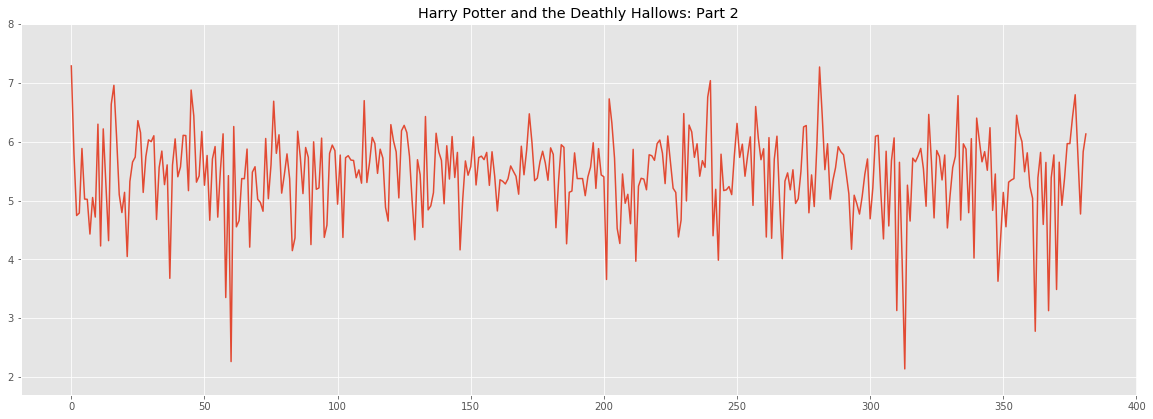

In [109]:
for movie in movieTitles:
    plt.figure(figsize=(20,15))
    plt.subplot(211)
    axes = plt.gca()
    axes.set_ylim([1.7,8])
    plt.plot(range(len(sentiment_senctences_dict[movie])), sentiment_senctences_dict[movie])
    plt.title(movie)

When looking at the graphs there seem to be a clear progression in the language as the movies becomes newer. The movies develop from children's movies to more adult/teenage movies. As the movies change the language changes at the same time, and this is what we can see in the graphs. Darker words as "Death" and "terror" are used, but at the same time stronger words as "love" and "pleasure" are also used. This results in a more noisy graph. The last two movies are especially noisy.

It is possible to relate some of the outliers with events from the actual movie. An example is the outlier around 315 in "Harry Potter and the Deathly Hallows: Part 2". At this point in the movie Harry dies and that can be seen from the negative language.

## Spells

Just as an interesting bonus analysis we looked at how often are some of the most used spells in the movies actually used.

We did this by first entering all the most common spells in to a list. We then took this list and look through the collected transcripts of all the movies, and counted the occurance of each spell.

In [110]:
spells = [
    "riddikulus",
    "obliviate",
    "avada",
    "alohomora",
    "lumos",
    "expelliarmus",
    "wingardium",
    "accio",
    "expecto",
    "imperio",
    "immobulus",
    "stupefy",
    "incendio",
    "alohomora",
]
numberOfSpells = []
for i in spells:
    numberOfSpells.append(allmovies.count(i))

Now we had all the spells and how many times they were said, and it is then easy to plot is as a bar plot, to show how they relate to each other.

Text(0,0.5,'Count')

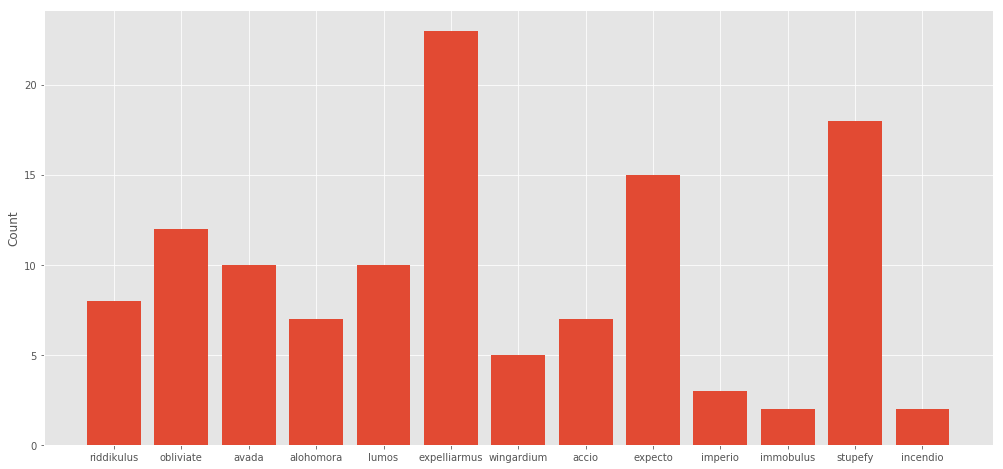

In [111]:
plt.figure(figsize=(17,8))
plt.bar(spells,numberOfSpells)
plt.ylabel('Count')

As can be seen from the bar plot the most used spell in the movies is Expelliaramus. It is the spell that flicks the wand out of a wizards hand practically leaving them defenceless. Another spell that most people know is Wingardium "Leviosa". This spell is actual only used 5 times, and another fun fact is that these 5 times were all in the first movie. 

# 4. Discussion

## What went well?
Generally we have explored a lot of interesting metrics an uncovered a lot of interresting information. It was very easy to use the tools and analysis methods from the course on our dataset. 

The sentiment analysis of the sentiment in the Wiki pages was very interesting after we took nods with more than 10 edges. It really gave an interesting view on the most positive characters. 

The community detection was also quite interesting even though it did not catch the house communities it found communities of teachers and students. This meant smaller more focused communities.

The transcript analysis when comparing the different movies gave results that were easy to interpret. The obvious development of the langauge in the movies and the big events were caught as outliers.

## What is still missing? What could be improved? Why?

A thing that probably should be done to further improve the quality of the analysis, is a more thorugh filtering of which nodes to include in the graph. We were able to remove some junk simply by removing all pages if they started with "User:" or "Template:", but there might be some other pages that are not related. An example of this is the node called "Draco Malfoy's gang", which is still present the graph that we used for this project, though it should probably have been removed, and there are probably other similar pages that would require manual filtering. All this goes back to the fact that the contributors of the Harry Potter Wikia, decides themselves which categories they think fit the most to the articles that they are writing, and this can lead to errors.

In the part where we inspected the words of each of the houses, we could have further improved the word clouds, by removing removing the names of other characters. Most of the words in the word cloud are actual names of characters and is thus not very interesting.

It could be interesting to take the communities we found with the Louvain algorithm and try and categorize them, to see what the all the different kinds of communities are. 

We chose only to focus on the characters on the Harry Potter Wikia. It is possible to include a lot more Wiki pages, as places, creaures and so forth. With this extra data more connection could have been found. 

The transcripts for the movies are poorly made and there is a high likely hood of mistakes, because it is community made. This makes the result slightly unreliable. It would also have been very good if the transcripts also had the name of the character saying the line. If this was true we could have made an analysis of the characters spoken language and with high possiblity we would have been able to find the good and bad characters.





